In [1]:
# Cell 1: Setup & Imports
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# allow imports from src/
sys.path.append(os.path.abspath(os.path.join("..", "src")))

from data.download_data import download_stock_data
from strategies.ml_model import train_xgboost, evaluate_model  # will create these next

In [2]:
# Cell 2: Load data & features
# Choose ticker & dates
ticker     = "JOBY"
start_date = "2024-01-01"
end_date   = "2024-06-30"

# Download or load from CSV
df = download_stock_data(ticker, start_date, end_date, save_csv=True)

# Basic feature engineering
df["MA_10"]    = df["Close"].rolling(10).mean()
df["MA_50"]    = df["Close"].rolling(50).mean()
df["Return1"]  = df["Close"].pct_change(1)
df["Return5"]  = df["Close"].pct_change(5)
df["Volatility"] = df["Close"].rolling(10).std()

# Target: will price close higher tomorrow?
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Drop NaNs
df.dropna(inplace=True)

📥 Downloading JOBY from Polygon.io...
[✓] Data saved to /home/flexiv/AlphaVestra/data/raw/JOBY.csv


In [3]:
# Cell 3: Train/test split
# Split by date (time-series split)
split_date = "2024-05-01"
train = df[df["Date"] < split_date]
test  = df[df["Date"] >= split_date]

X_train = train[["MA_10","MA_50","Return1","Return5","Volatility"]]
y_train = train["Target"]
X_test  = test[["MA_10","MA_50","Return1","Return5","Volatility"]]
y_test  = test["Target"]

In [4]:
# Cell 4: Model training
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X_train, y_train)

/home/flexiv/AlphaVestra/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Accuracy: 0.5609756097560976
              precision    recall  f1-score   support

           0       0.82      0.36      0.50        25
           1       0.47      0.88      0.61        16

    accuracy                           0.56        41
   macro avg       0.64      0.62      0.55        41
weighted avg       0.68      0.56      0.54        41



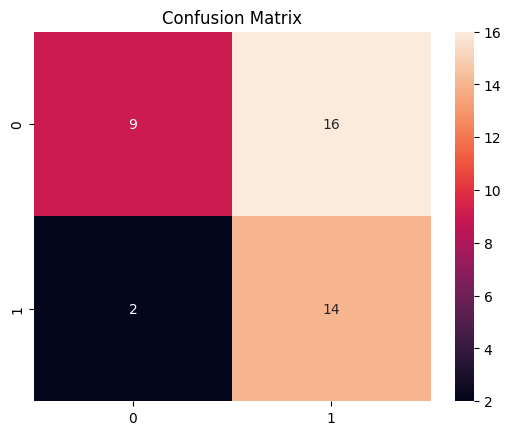

In [5]:
# Cell 5: Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


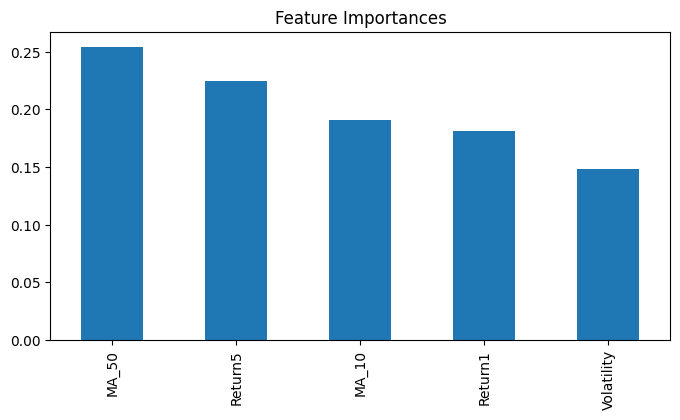

In [6]:
# Cell 6: Feature importance
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
feat_imp.plot.bar()
plt.title("Feature Importances")
plt.show()

In [7]:
# Cell 7: Save model
import joblib

os.makedirs("models", exist_ok=True)
joblib.dump(model, f"models/{ticker}_xgb_model.pkl")
print("Model saved.")


Model saved.
